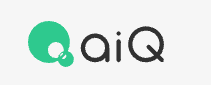

[disclaimer](../../disclaimer.txt/)

# TruValue Data Evaluation

- Factset TruValue is an ESG data source that provides insights from unstructured text using AI-driven sentiment scores.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
import pandas as pd
import plotly.io
from aiq_strategy_robot.data.data_accessor import DAL

for_html = False
if for_html:
    plotly.offline.init_notebook_mode()
else:
    plotly.io.renderers.default = 'iframe'

sys.path.append('../..')

from libs.dataset import truvalue as sc

## Data Loading & Creating AltDataEvaluator

- Create an instance of the standard data handler.
- The data handler is an object that holds libraries for data acquisition and processing.

In [3]:
sdh = DAL()

In this sample, we will use a sample data file for the subsequent explanations.

In [4]:
# Price Data (origin: FactSet HTTP API)
data_id_price = sc.register_market_prices(sdh)
display(sdh.get_raw_data(data_id_price).tail())


# ☆TruValue data (origin: FactSet Snowflake)
data_id_tv = sc.register_tv(sdh)
display(sdh.get_raw_data(data_id_tv).tail())

# Set Alias (Optional)
sdh.set_alias({
    data_id_price: 'mkt',
    data_id_tv: 'truvalue',
})

sdh.extract_definition


fsymId  TICKER_REGION    volume   open   high    low  \
TICKER  DATETIME                                                             
9997-JP 2023-10-27  BT5ZHY-R           9997  290300.0  622.0  628.0  622.0   
        2023-10-30  BT5ZHY-R           9997  409300.0  622.0  625.0  607.0   
        2023-10-31  BT5ZHY-R           9997  528300.0  610.0  613.0  604.0   
        2023-11-01  BT5ZHY-R           9997  421200.0  627.0  633.0  619.0   
        2023-11-02  BT5ZHY-R           9997  323800.0  631.0  631.0  621.0   

                    close currency  
TICKER  DATETIME                    
9997-JP 2023-10-27  626.0      JPY  
        2023-10-30  612.0      JPY  
        2023-10-31  612.0      JPY  
        2023-11-01  628.0      JPY  
        2023-11-02  628.0      JPY

MATERIALITY_ADJ_INSIGHT  MATERIALITY_IND_PCTL  \
TICKER  DATETIME                                                    
9997-JP 2023-11-16                    64.42                 40.63   
        2023-11-17                    64.41                 40.35   
        2023-11-18                    64.40                 40.28   
        2023-11-19                    64.35                 40.37   
        2023-11-20                    64.40                 40.23   

                    ALL_CATEGORIES_ADJ_INSIGHT  ALL_CATEGORIES_INSIGHT  \
TICKER  DATETIME                                                         
9997-JP 2023-11-16                       76.55               76.545724   
        2023-11-17                       76.56               76.564881   
        2023-11-18                       76.58               76.583965   
        2023-11-19                       76.60               76.602976   
        2023-11-20                       76.62               76.621916   

                    ALL_CATEGORIES_MOMENTUM  ALL_CATEGORIES_PULSE  
TICKER  DATETIME                                                   
9997-JP 2023-11-16                81.457731               81.5853  
        2023-11-17                81.409830               81.5853  
        2023-11-18                81.362007               81.5853  
        2023-11-19                81.314263               81.5853  
        2023-11-20                81.266596               81.5853

category data_source      source    table     alias  \
data_id                                                       
1        RawData     FACTSET  gpd_prices  Unknown       mkt   
2        RawData     FACTSET   TrueValue  Unknown  truvalue   

                                                   tickers  \
data_id                                                      
1        [1301-JP, 1332-JP, 1333-JP, 1379-JP, 1380-JP, ...   
2        [1301-JP, 1332-JP, 1333-JP, 1379-JP, 1380-JP, ...   

                      index       start_datetime         end_datetime  
data_id                                                                
1        [TICKER, DATETIME]  2016-01-04 00:00:00  2023-11-02 00:00:00  
2        [TICKER, DATETIME]  2016-01-01 00:00:00  2023-11-20 00:00:00

### Create an AltDataEvaluator

In [5]:
from aiq_strategy_robot.evaluator import AltDataEvaluator

# Initialize AltDataEvaluator
ade = AltDataEvaluator(sdh)

## Correlation Calculation

Given the nature of Factset TruValue data, it is expected that there is a correlation between financial data (quarterly sales).  

Here, we will test this hypothesis to determine its validity.

### Correlation with Stock Price Changes

> Here, we will convert the data to weekly frequency and perform the analysis.

In [6]:
resample_term = 'W-FRI'

mkt_W_open_id = sdh.transform.resample(data_id=data_id_price, fields='open', rule=resample_term, func='first', label='left', closed='left').variable_ids[-1]

tv_last_W_ids = sdh.transform.resample(data_id=data_id_tv, rule=resample_term, func='last', label='left', closed='left').variable_ids
tv_mean_W_ids = sdh.transform.resample(data_id=data_id_tv, rule=resample_term, func='mean', label='left', closed='left').variable_ids
tv_sum_W_ids = sdh.transform.resample(data_id=data_id_tv, rule=resample_term, func='sum', label='left', closed='left').variable_ids

In [7]:
ori_cols = sdh.get_raw_data(data_id_tv).columns.to_list()
ori_cols

['MATERIALITY_ADJ_INSIGHT',
 'MATERIALITY_IND_PCTL',
 'ALL_CATEGORIES_ADJ_INSIGHT',
 'ALL_CATEGORIES_INSIGHT',
 'ALL_CATEGORIES_MOMENTUM',
 'ALL_CATEGORIES_PULSE']

#### Check Correlation by Aggregation Method for TruValue

##### 1. resample by last

Plot Price Data and TruValue

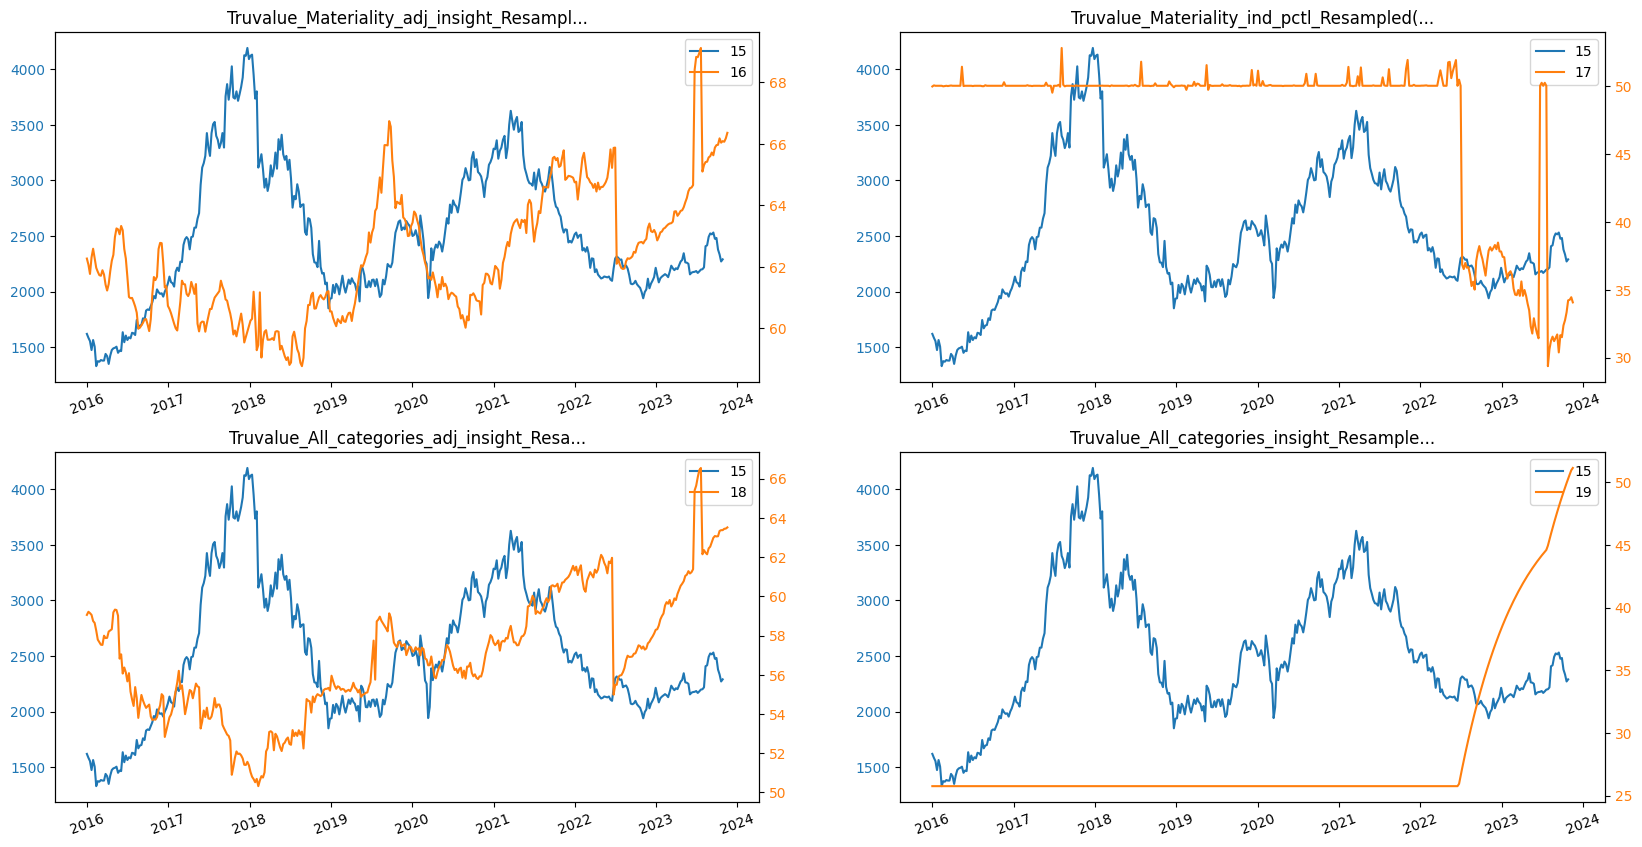

In [8]:
sample_target = "2281-JP"

sdh.show_line_one_target(
    target=sample_target,
    y=mkt_W_open_id,
    X= tv_last_W_ids[:4],
    col_num=2,
    vname_len_limit=40,
)

> Examine how the plot with sales data changes by shifting the time series.

In [9]:
tv_shift4_last_W_ids = sdh.transform.shift(data_id=data_id_tv, periods=4).resample(rule=resample_term, func='last', label='left', closed='left').variable_ids
tv_shift8_last_W_ids = sdh.transform.shift(data_id=data_id_tv, periods=8).resample(rule=resample_term, func='last', label='left', closed='left').variable_ids
tv_shift12_last_W_ids = sdh.transform.shift(data_id=data_id_tv, periods=12).resample(rule=resample_term, func='last', label='left', closed='left').variable_ids
tv_shift16_last_W_ids = sdh.transform.shift(data_id=data_id_tv, periods=16).resample(rule=resample_term, func='last', label='left', closed='left').variable_ids
tv_shift20_last_W_ids = sdh.transform.shift(data_id=data_id_tv, periods=20).resample(rule=resample_term, func='last', label='left', closed='left').variable_ids

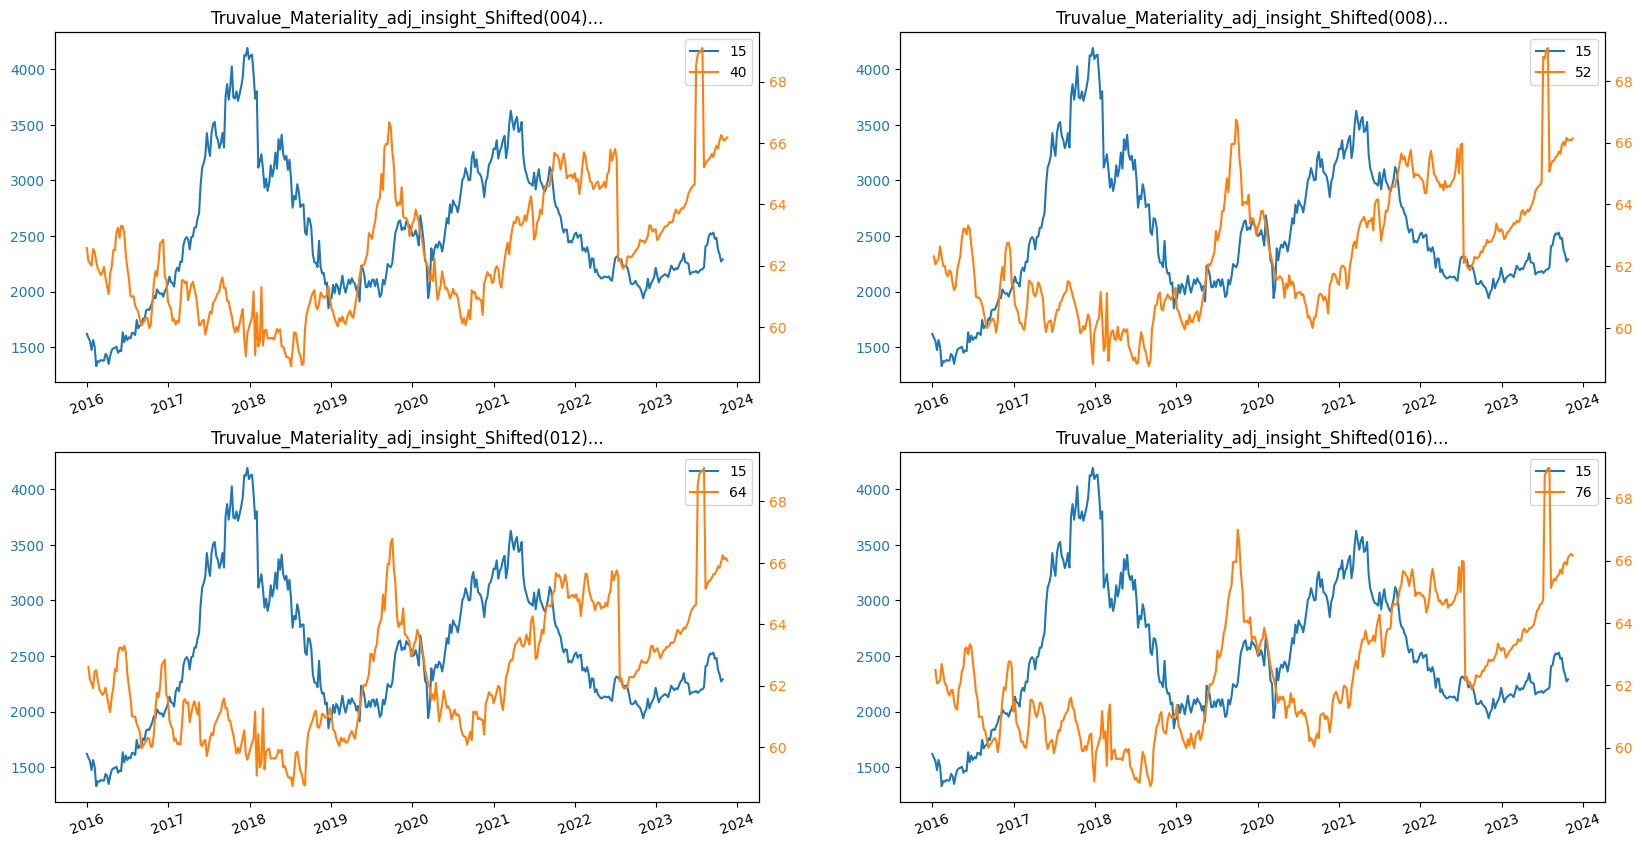

In [10]:
sdh.show_line_one_target(
    target=sample_target,
    y=mkt_W_open_id,
    X= [tv_shift4_last_W_ids[0], tv_shift8_last_W_ids[0], 
        tv_shift12_last_W_ids[0], tv_shift16_last_W_ids[0]],
    col_num=2,
    vname_len_limit=45,
)

> Perform correlation calculations by applying a logarithmic transformation to the features.  
> Use TruValue as is, with only shifts applied.

In [11]:
# open_return = sdh.transform.dropna(fields=mkt_W_open_id).log_diff(periods=1).mul_val(value=100).variable_ids[-1]
open_return = sdh.transform.dropna(fields=mkt_W_open_id).calc_return().variable_ids[-1]
sdh.transform.set_return_type()

variable_id  data_id  \
variable_name                                                              
Mkt_Open_Resampled(W-FRI|first, closed="left", ...           95        1   

                                                   root_field return_type  \
variable_name                                                               
Mkt_Open_Resampled(W-FRI|first, closed="left", ...       open  arithmetic   

                                                   other_roots  \
variable_name                                                    
Mkt_Open_Resampled(W-FRI|first, closed="left", ...           -   

                                                                                             step_001  \
variable_name                                                                                           
Mkt_Open_Resampled(W-FRI|first, closed="left", ...  resample(rule="W-FRI", func="first", closed="l...   

                                                             step_002  \
variable_name                                                           
Mkt_Open_Resampled(W-FRI|first, closed="left", ...  dropna(how="any")   

                                                                                  step_003  
variable_name                                                                               
Mkt_Open_Resampled(W-FRI|first, closed="left", ...  pct_change(periods=1, drop_minus=True)

In [12]:
rho_pool_last = pd.DataFrame()
rho_pool_last['resample-last, shift=0'] = ade.compu_rho(tv_last_W_ids, open_return, rename_features=ori_cols)
rho_pool_last['resample-last, shift=4'] = ade.compu_rho(tv_shift4_last_W_ids, open_return, rename_features=ori_cols)
rho_pool_last['resample-last, shift=8'] = ade.compu_rho(tv_shift8_last_W_ids, open_return, rename_features=ori_cols)
rho_pool_last['resample-last, shift=12'] = ade.compu_rho(tv_shift12_last_W_ids, open_return, rename_features=ori_cols)
rho_pool_last['resample-last, shift=16'] = ade.compu_rho(tv_shift16_last_W_ids, open_return, rename_features=ori_cols)
rho_pool_last['resample-last, shift=20'] = ade.compu_rho(tv_shift20_last_W_ids, open_return, rename_features=ori_cols)

display(rho_pool_last.xs('t-val', level=1).sort_values(rho_pool_last.columns[0], ascending=False))

resample-last, shift=0  resample-last, shift=4  \
ALL_CATEGORIES_PULSE                      3.344152                2.860057   
ALL_CATEGORIES_INSIGHT                    2.977150                2.951975   
ALL_CATEGORIES_MOMENTUM                   2.477017                2.465337   
MATERIALITY_ADJ_INSIGHT                   1.705424                1.616745   
MATERIALITY_IND_PCTL                      1.439047                0.736938   
ALL_CATEGORIES_ADJ_INSIGHT                0.726596                0.735482   

                            resample-last, shift=8  resample-last, shift=12  \
ALL_CATEGORIES_PULSE                      2.868005                 2.448300   
ALL_CATEGORIES_INSIGHT                    2.924106                 2.944952   
ALL_CATEGORIES_MOMENTUM                   2.414707                 2.395866   
MATERIALITY_ADJ_INSIGHT                   1.570667                 1.543095   
MATERIALITY_IND_PCTL                      0.628287                 2.176816   
ALL_CATEGORIES_ADJ_INSIGHT                0.668247                 0.700607   

                            resample-last, shift=16  resample-last, shift=20  
ALL_CATEGORIES_PULSE                       2.339968                 2.217786  
ALL_CATEGORIES_INSIGHT                     2.747770                 2.664021  
ALL_CATEGORIES_MOMENTUM                    2.250225                 2.160096  
MATERIALITY_ADJ_INSIGHT                    1.373798                 1.279600  
MATERIALITY_IND_PCTL                       1.348569                 0.000145  
ALL_CATEGORIES_ADJ_INSIGHT                 0.372432                 0.158734

> Among the variables with the highest correlation, further review the top N tickers.

In [13]:
rho_time = ade.compu_rho(tv_last_W_ids, open_return, by='ticker', rename_features=ori_cols)
rho_time.T.xs('t-val', level=1).sort_values('ALL_CATEGORIES_PULSE', ascending=False).head()

/home/schiba/miniconda3/envs/sample/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/home/schiba/miniconda3/envs/sample/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/home/schiba/miniconda3/envs/sample/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



MATERIALITY_ADJ_INSIGHT  MATERIALITY_IND_PCTL  \
TICKER                                                   
2109-JP                 0.850243              2.340498   
2805-JP                 1.622317              2.408400   
2914-JP                 2.050671             -0.880109   
4188-JP                 1.891842              2.332360   
2267-JP                 0.774713              0.538611   

         ALL_CATEGORIES_ADJ_INSIGHT  ALL_CATEGORIES_INSIGHT  \
TICKER                                                        
2109-JP                    2.254025                3.745240   
2805-JP                    1.588009                3.242712   
2914-JP                    2.627628                2.627770   
4188-JP                    2.365212                2.363773   
2267-JP                    0.832847                0.832744   

         ALL_CATEGORIES_MOMENTUM  ALL_CATEGORIES_PULSE  
TICKER                                                  
2109-JP                 2.405511              3.472942  
2805-JP                 3.003294              3.092613  
2914-JP                 0.936111              2.446329  
4188-JP                 2.895031              2.292204  
2267-JP                 1.718979              2.103774

In [14]:
display(sdh.transform.find_variables(tv_last_W_ids))

feature_last = 7 # ALL_CATEGORIES_PULSE

variable_id  data_id  \
variable_name                                                              
Truvalue_Materiality_adj_insight_Resampled(W-FR...           16        2   
Truvalue_Materiality_ind_pctl_Resampled(W-FRI|l...           17        2   
Truvalue_All_categories_adj_insight_Resampled(W...           18        2   
Truvalue_All_categories_insight_Resampled(W-FRI...           19        2   
Truvalue_All_categories_momentum_Resampled(W-FR...           20        2   
Truvalue_All_categories_pulse_Resampled(W-FRI|l...           21        2   

                                                                    root_field  \
variable_name                                                                    
Truvalue_Materiality_adj_insight_Resampled(W-FR...     MATERIALITY_ADJ_INSIGHT   
Truvalue_Materiality_ind_pctl_Resampled(W-FRI|l...        MATERIALITY_IND_PCTL   
Truvalue_All_categories_adj_insight_Resampled(W...  ALL_CATEGORIES_ADJ_INSIGHT   
Truvalue_All_categories_insight_Resampled(W-FRI...      ALL_CATEGORIES_INSIGHT   
Truvalue_All_categories_momentum_Resampled(W-FR...     ALL_CATEGORIES_MOMENTUM   
Truvalue_All_categories_pulse_Resampled(W-FRI|l...        ALL_CATEGORIES_PULSE   

                                                   return_type other_roots  \
variable_name                                                                
Truvalue_Materiality_adj_insight_Resampled(W-FR...           -           -   
Truvalue_Materiality_ind_pctl_Resampled(W-FRI|l...           -           -   
Truvalue_All_categories_adj_insight_Resampled(W...           -           -   
Truvalue_All_categories_insight_Resampled(W-FRI...           -           -   
Truvalue_All_categories_momentum_Resampled(W-FR...           -           -   
Truvalue_All_categories_pulse_Resampled(W-FRI|l...           -           -   

                                                                                             step_001  
variable_name                                                                                          
Truvalue_Materiality_adj_insight_Resampled(W-FR...  resample(rule="W-FRI", func="last", closed="le...  
Truvalue_Materiality_ind_pctl_Resampled(W-FRI|l...  resample(rule="W-FRI", func="last", closed="le...  
Truvalue_All_categories_adj_insight_Resampled(W...  resample(rule="W-FRI", func="last", closed="le...  
Truvalue_All_categories_insight_Resampled(W-FRI...  resample(rule="W-FRI", func="last", closed="le...  
Truvalue_All_categories_momentum_Resampled(W-FR...  resample(rule="W-FRI", func="last", closed="le...  
Truvalue_All_categories_pulse_Resampled(W-FRI|l...  resample(rule="W-FRI", func="last", closed="le...

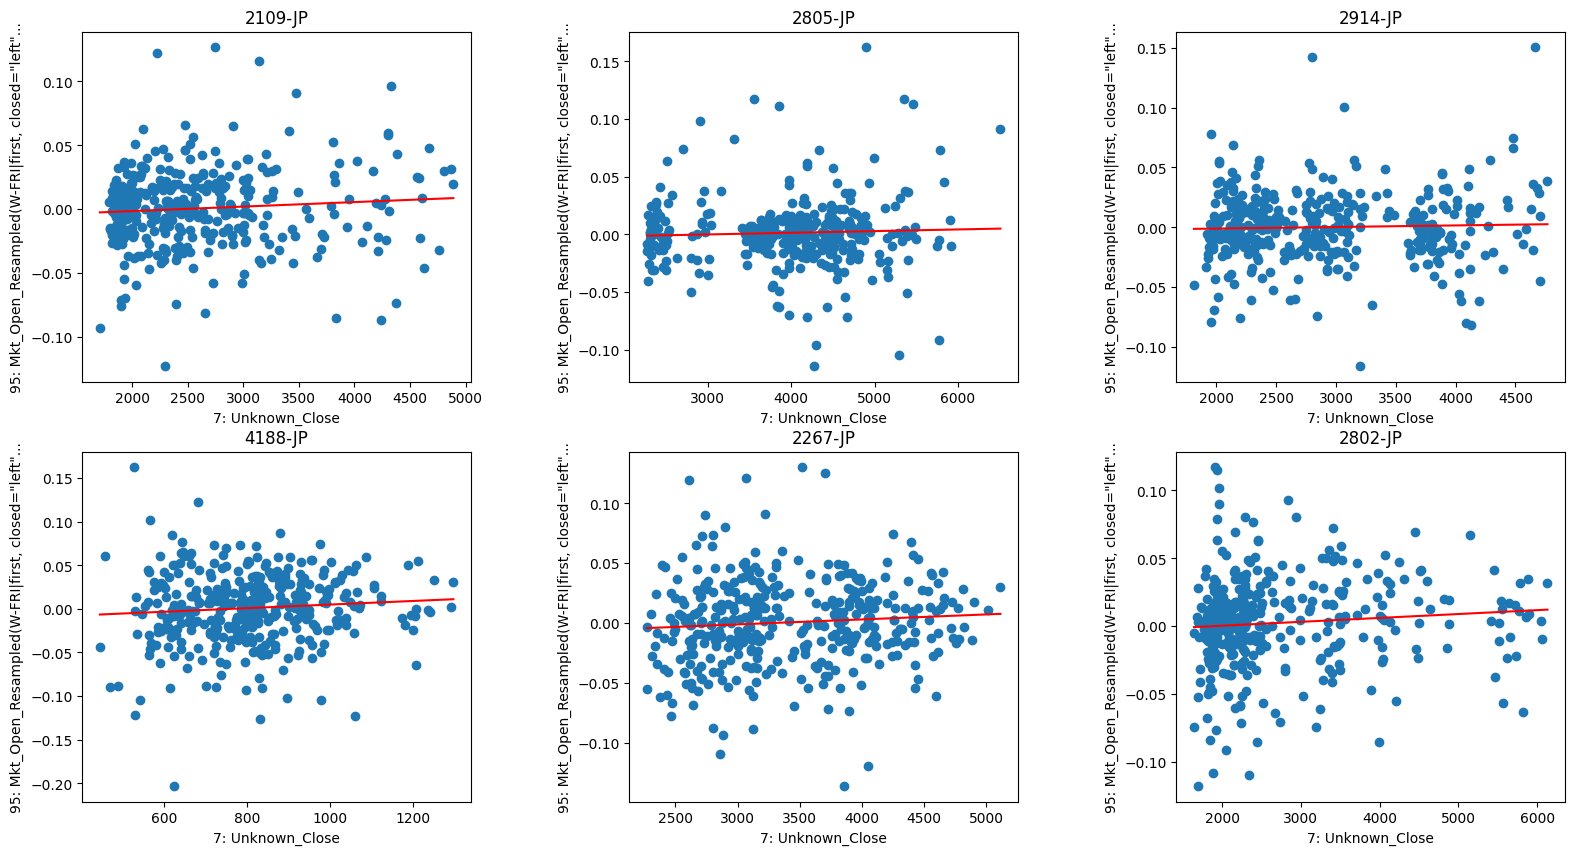

In [15]:
top6tickers = rho_time.T.xs('t-val', level=1).sort_values('ALL_CATEGORIES_PULSE', ascending=False).index[:6]

sdh.show_scatter_per_target(
    y=open_return,
    x=feature_last,
    targets=top6tickers,
    col_num=3,
    vname_len_limit=45
)

##### 2.resample by mean

In [16]:
tv_shift4_mean_W_ids = sdh.transform.shift(data_id=data_id_tv, periods=4).resample(rule=resample_term, func='mean', label='left', closed='left').variable_ids
tv_shift8_mean_W_ids = sdh.transform.shift(data_id=data_id_tv, periods=8).resample(rule=resample_term, func='mean', label='left', closed='left').variable_ids
tv_shift12_mean_W_ids = sdh.transform.shift(data_id=data_id_tv, periods=12).resample(rule=resample_term, func='mean', label='left', closed='left').variable_ids
tv_shift16_mean_W_ids = sdh.transform.shift(data_id=data_id_tv, periods=16).resample(rule=resample_term, func='mean', label='left', closed='left').variable_ids
tv_shift20_mean_W_ids = sdh.transform.shift(data_id=data_id_tv, periods=20).resample(rule=resample_term, func='mean', label='left', closed='left').variable_ids

In [17]:
rho_pool_mean = pd.DataFrame()
rho_pool_mean['resample-mean, shift=0'] = ade.compu_rho(tv_mean_W_ids, open_return, rename_features=ori_cols)
rho_pool_mean['resample-mean, shift=4'] = ade.compu_rho(tv_shift4_mean_W_ids, open_return, rename_features=ori_cols)
rho_pool_mean['resample-mean, shift=8'] = ade.compu_rho(tv_shift8_mean_W_ids, open_return, rename_features=ori_cols)
rho_pool_mean['resample-mean, shift=12'] = ade.compu_rho(tv_shift12_mean_W_ids, open_return, rename_features=ori_cols)
rho_pool_mean['resample-mean, shift=16'] = ade.compu_rho(tv_shift16_mean_W_ids, open_return, rename_features=ori_cols)
rho_pool_mean['resample-mean, shift=20'] = ade.compu_rho(tv_shift20_mean_W_ids, open_return, rename_features=ori_cols)

display(rho_pool_mean.xs('t-val', level=1).sort_values(rho_pool_mean.columns[0], ascending=False))

resample-mean, shift=0  resample-mean, shift=4  \
ALL_CATEGORIES_PULSE                      3.027902                2.748269   
ALL_CATEGORIES_INSIGHT                    2.952560                2.944192   
ALL_CATEGORIES_MOMENTUM                   2.470127                2.439561   
MATERIALITY_IND_PCTL                      1.808312                0.697987   
MATERIALITY_ADJ_INSIGHT                   1.668807                1.592868   
ALL_CATEGORIES_ADJ_INSIGHT                0.725195                0.710612   

                            resample-mean, shift=8  resample-mean, shift=12  \
ALL_CATEGORIES_PULSE                      2.600764                 2.476510   
ALL_CATEGORIES_INSIGHT                    2.914541                 2.937219   
ALL_CATEGORIES_MOMENTUM                   2.408915                 2.415238   
MATERIALITY_IND_PCTL                      1.792406                 1.504801   
MATERIALITY_ADJ_INSIGHT                   1.543739                 1.579401   
ALL_CATEGORIES_ADJ_INSIGHT                0.682806                 0.690015   

                            resample-mean, shift=16  resample-mean, shift=20  
ALL_CATEGORIES_PULSE                       2.268093                 2.236214  
ALL_CATEGORIES_INSIGHT                     2.740561                 2.659710  
ALL_CATEGORIES_MOMENTUM                    2.214726                 2.127981  
MATERIALITY_IND_PCTL                      -0.638772                 0.290346  
MATERIALITY_ADJ_INSIGHT                    1.394647                 1.211096  
ALL_CATEGORIES_ADJ_INSIGHT                 0.340530                 0.067082

> Review the top N tickers mentioned above.

In [18]:
rho_time = ade.compu_rho(tv_mean_W_ids, open_return, by='ticker', rename_features=ori_cols)
rho_time.T.xs('t-val', level=1).sort_values('ALL_CATEGORIES_PULSE', ascending=False).head()

/home/schiba/miniconda3/envs/sample/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/home/schiba/miniconda3/envs/sample/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/home/schiba/miniconda3/envs/sample/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



MATERIALITY_ADJ_INSIGHT  MATERIALITY_IND_PCTL  \
TICKER                                                   
2109-JP                 0.885630              2.035094   
2805-JP                 1.664397              2.098742   
2914-JP                 2.000718             -0.951211   
8058-JP                 1.360739              0.770681   
9942-JP                 0.985791              0.556496   

         ALL_CATEGORIES_ADJ_INSIGHT  ALL_CATEGORIES_INSIGHT  \
TICKER                                                        
2109-JP                    2.152633                3.727871   
2805-JP                    1.585890                3.242712   
2914-JP                    2.586101                2.587092   
8058-JP                    1.396332                1.397143   
9942-JP                    1.113459                1.720045   

         ALL_CATEGORIES_MOMENTUM  ALL_CATEGORIES_PULSE  
TICKER                                                  
2109-JP                 2.367188              3.582892  
2805-JP                 3.018095              3.004423  
2914-JP                 0.869098              2.394223  
8058-JP                 1.169467              2.142156  
9942-JP                 0.941901              1.989675

In [19]:
display(sdh.transform.find_variables(tv_mean_W_ids))

feature_mean = 13 # ALL_CATEGORIES_PULSE
feature_mean_m = 8  # MATERIALITY_ADJ_INSIGHT

variable_id  data_id  \
variable_name                                                              
Truvalue_Materiality_adj_insight_Resampled(W-FR...           22        2   
Truvalue_Materiality_ind_pctl_Resampled(W-FRI|m...           23        2   
Truvalue_All_categories_adj_insight_Resampled(W...           24        2   
Truvalue_All_categories_insight_Resampled(W-FRI...           25        2   
Truvalue_All_categories_momentum_Resampled(W-FR...           26        2   
Truvalue_All_categories_pulse_Resampled(W-FRI|m...           27        2   

                                                                    root_field  \
variable_name                                                                    
Truvalue_Materiality_adj_insight_Resampled(W-FR...     MATERIALITY_ADJ_INSIGHT   
Truvalue_Materiality_ind_pctl_Resampled(W-FRI|m...        MATERIALITY_IND_PCTL   
Truvalue_All_categories_adj_insight_Resampled(W...  ALL_CATEGORIES_ADJ_INSIGHT   
Truvalue_All_categories_insight_Resampled(W-FRI...      ALL_CATEGORIES_INSIGHT   
Truvalue_All_categories_momentum_Resampled(W-FR...     ALL_CATEGORIES_MOMENTUM   
Truvalue_All_categories_pulse_Resampled(W-FRI|m...        ALL_CATEGORIES_PULSE   

                                                   return_type other_roots  \
variable_name                                                                
Truvalue_Materiality_adj_insight_Resampled(W-FR...           -           -   
Truvalue_Materiality_ind_pctl_Resampled(W-FRI|m...           -           -   
Truvalue_All_categories_adj_insight_Resampled(W...           -           -   
Truvalue_All_categories_insight_Resampled(W-FRI...           -           -   
Truvalue_All_categories_momentum_Resampled(W-FR...           -           -   
Truvalue_All_categories_pulse_Resampled(W-FRI|m...           -           -   

                                                                                             step_001  
variable_name                                                                                          
Truvalue_Materiality_adj_insight_Resampled(W-FR...  resample(rule="W-FRI", func="mean", closed="le...  
Truvalue_Materiality_ind_pctl_Resampled(W-FRI|m...  resample(rule="W-FRI", func="mean", closed="le...  
Truvalue_All_categories_adj_insight_Resampled(W...  resample(rule="W-FRI", func="mean", closed="le...  
Truvalue_All_categories_insight_Resampled(W-FRI...  resample(rule="W-FRI", func="mean", closed="le...  
Truvalue_All_categories_momentum_Resampled(W-FR...  resample(rule="W-FRI", func="mean", closed="le...  
Truvalue_All_categories_pulse_Resampled(W-FRI|m...  resample(rule="W-FRI", func="mean", closed="le...

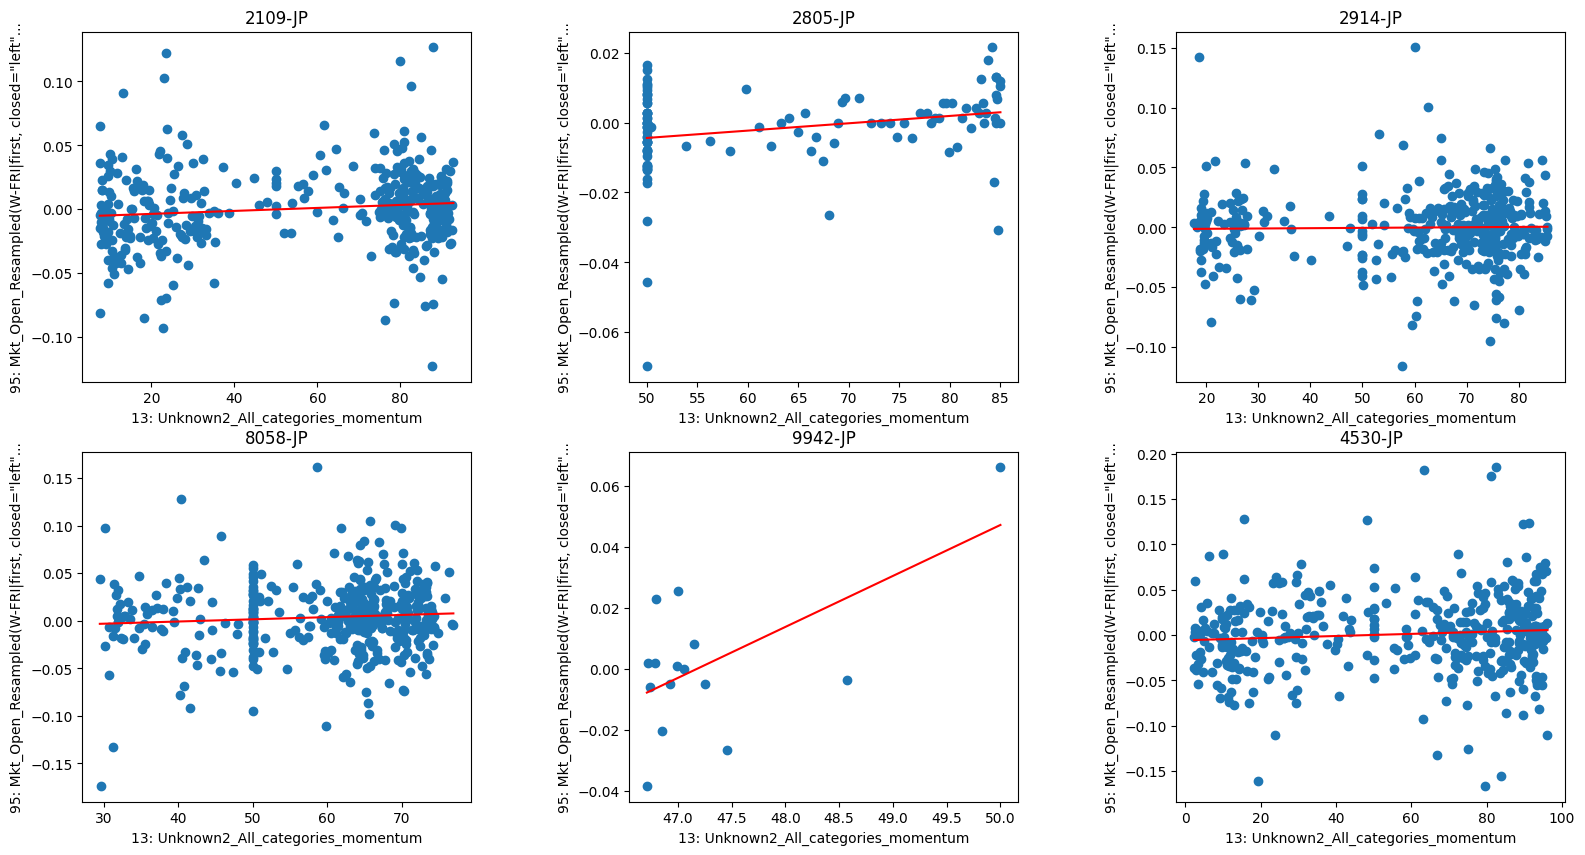

In [20]:
top6tickers = rho_time.T.xs('t-val', level=1).sort_values('ALL_CATEGORIES_PULSE', ascending=False).index[:6]

sdh.show_scatter_per_target(
    y=open_return,
    x=feature_mean,
    targets=top6tickers,
    col_num=3,
    vname_len_limit=45
)

##### 3. resample by sum

In [21]:
tv_shift4_sum_W_ids = sdh.transform.shift(data_id=data_id_tv, periods=4).resample(rule=resample_term, func='sum', label='left', closed='left').variable_ids
tv_shift8_sum_W_ids = sdh.transform.shift(data_id=data_id_tv, periods=8).resample(rule=resample_term, func='sum', label='left', closed='left').variable_ids
tv_shift12_sum_W_ids = sdh.transform.shift(data_id=data_id_tv, periods=12).resample(rule=resample_term, func='sum', label='left', closed='left').variable_ids
tv_shift16_sum_W_ids = sdh.transform.shift(data_id=data_id_tv, periods=16).resample(rule=resample_term, func='sum', label='left', closed='left').variable_ids
tv_shift20_sum_W_ids = sdh.transform.shift(data_id=data_id_tv, periods=20).resample(rule=resample_term, func='sum', label='left', closed='left').variable_ids

In [22]:
rho_pool_sum = pd.DataFrame()
rho_pool_sum['resample-sum, shift=0'] = ade.compu_rho(tv_sum_W_ids, open_return, rename_features=ori_cols)
rho_pool_sum['resample-sum, shift=4'] = ade.compu_rho(tv_shift4_sum_W_ids, open_return, rename_features=ori_cols)
rho_pool_sum['resample-sum, shift=8'] = ade.compu_rho(tv_shift8_sum_W_ids, open_return, rename_features=ori_cols)
rho_pool_sum['resample-sum, shift=12'] = ade.compu_rho(tv_shift12_sum_W_ids, open_return, rename_features=ori_cols)
rho_pool_sum['resample-sum, shift=16'] = ade.compu_rho(tv_shift16_sum_W_ids, open_return, rename_features=ori_cols)
rho_pool_sum['resample-sum, shift=20'] = ade.compu_rho(tv_shift20_sum_W_ids, open_return, rename_features=ori_cols)

display(rho_pool_sum.xs('t-val', level=1).sort_values(rho_pool_sum.columns[0], ascending=False))

resample-sum, shift=0  resample-sum, shift=4  \
ALL_CATEGORIES_INSIGHT                   3.500421               3.503341   
ALL_CATEGORIES_PULSE                     3.461847               3.348935   
ALL_CATEGORIES_MOMENTUM                  3.259602               3.274313   
MATERIALITY_IND_PCTL                     2.911425               2.219406   
MATERIALITY_ADJ_INSIGHT                  2.850379               2.858777   
ALL_CATEGORIES_ADJ_INSIGHT               2.237807               2.267289   

                            resample-sum, shift=8  resample-sum, shift=12  \
ALL_CATEGORIES_INSIGHT                   3.786245                3.901586   
ALL_CATEGORIES_PULSE                     3.532398                3.684571   
ALL_CATEGORIES_MOMENTUM                  3.398103                3.673736   
MATERIALITY_IND_PCTL                     3.411863                3.461282   
MATERIALITY_ADJ_INSIGHT                  3.454061                3.525775   
ALL_CATEGORIES_ADJ_INSIGHT               2.837428                2.867878   

                            resample-sum, shift=16  resample-sum, shift=20  
ALL_CATEGORIES_INSIGHT                    4.424969                4.601281  
ALL_CATEGORIES_PULSE                      4.166741                4.395593  
ALL_CATEGORIES_MOMENTUM                   4.132538                4.365328  
MATERIALITY_IND_PCTL                      2.707552                3.512710  
MATERIALITY_ADJ_INSIGHT                   4.061424                4.164000  
ALL_CATEGORIES_ADJ_INSIGHT                3.359647                3.418917

> Review the top N tickers among those with the highest correlation values.

In [23]:
rho_time = ade.compu_rho(tv_sum_W_ids, open_return, by='ticker', rename_features=ori_cols)
rho_time.T.xs('t-val', level=1).sort_values('ALL_CATEGORIES_PULSE', ascending=False).head()

/home/schiba/miniconda3/envs/sample/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/home/schiba/miniconda3/envs/sample/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/home/schiba/miniconda3/envs/sample/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



MATERIALITY_ADJ_INSIGHT  MATERIALITY_IND_PCTL  \
TICKER                                                   
2109-JP                 0.885630              2.035094   
2216-JP                 3.330121              2.982400   
2914-JP                 2.000718             -0.951211   
5410-JP                 1.457920             -0.072119   
8058-JP                 1.360388              0.770681   

         ALL_CATEGORIES_ADJ_INSIGHT  ALL_CATEGORIES_INSIGHT  \
TICKER                                                        
2109-JP                    2.152633                3.727871   
2216-JP                    3.335154                3.401057   
2914-JP                    2.586101                2.587092   
5410-JP                    0.979726                2.488197   
8058-JP                    1.396025                1.397143   

         ALL_CATEGORIES_MOMENTUM  ALL_CATEGORIES_PULSE  
TICKER                                                  
2109-JP                 2.367188              3.582892  
2216-JP                 2.990446              3.251964  
2914-JP                 0.869098              2.394223  
5410-JP                 2.549637              2.342830  
8058-JP                 1.169467              2.142156

> Check the variables and plot them using scatter plots.

In [24]:
display(sdh.transform.find_variables(tv_sum_W_ids))

feature_sum = 19 # ALL_CATEGORIES_PULSE

variable_id  data_id  \
variable_name                                                              
Truvalue_Materiality_adj_insight_Resampled(W-FR...           28        2   
Truvalue_Materiality_ind_pctl_Resampled(W-FRI|s...           29        2   
Truvalue_All_categories_adj_insight_Resampled(W...           30        2   
Truvalue_All_categories_insight_Resampled(W-FRI...           31        2   
Truvalue_All_categories_momentum_Resampled(W-FR...           32        2   
Truvalue_All_categories_pulse_Resampled(W-FRI|s...           33        2   

                                                                    root_field  \
variable_name                                                                    
Truvalue_Materiality_adj_insight_Resampled(W-FR...     MATERIALITY_ADJ_INSIGHT   
Truvalue_Materiality_ind_pctl_Resampled(W-FRI|s...        MATERIALITY_IND_PCTL   
Truvalue_All_categories_adj_insight_Resampled(W...  ALL_CATEGORIES_ADJ_INSIGHT   
Truvalue_All_categories_insight_Resampled(W-FRI...      ALL_CATEGORIES_INSIGHT   
Truvalue_All_categories_momentum_Resampled(W-FR...     ALL_CATEGORIES_MOMENTUM   
Truvalue_All_categories_pulse_Resampled(W-FRI|s...        ALL_CATEGORIES_PULSE   

                                                   return_type other_roots  \
variable_name                                                                
Truvalue_Materiality_adj_insight_Resampled(W-FR...           -           -   
Truvalue_Materiality_ind_pctl_Resampled(W-FRI|s...           -           -   
Truvalue_All_categories_adj_insight_Resampled(W...           -           -   
Truvalue_All_categories_insight_Resampled(W-FRI...           -           -   
Truvalue_All_categories_momentum_Resampled(W-FR...           -           -   
Truvalue_All_categories_pulse_Resampled(W-FRI|s...           -           -   

                                                                                             step_001  
variable_name                                                                                          
Truvalue_Materiality_adj_insight_Resampled(W-FR...  resample(rule="W-FRI", func="sum", closed="lef...  
Truvalue_Materiality_ind_pctl_Resampled(W-FRI|s...  resample(rule="W-FRI", func="sum", closed="lef...  
Truvalue_All_categories_adj_insight_Resampled(W...  resample(rule="W-FRI", func="sum", closed="lef...  
Truvalue_All_categories_insight_Resampled(W-FRI...  resample(rule="W-FRI", func="sum", closed="lef...  
Truvalue_All_categories_momentum_Resampled(W-FR...  resample(rule="W-FRI", func="sum", closed="lef...  
Truvalue_All_categories_pulse_Resampled(W-FRI|s...  resample(rule="W-FRI", func="sum", closed="lef...

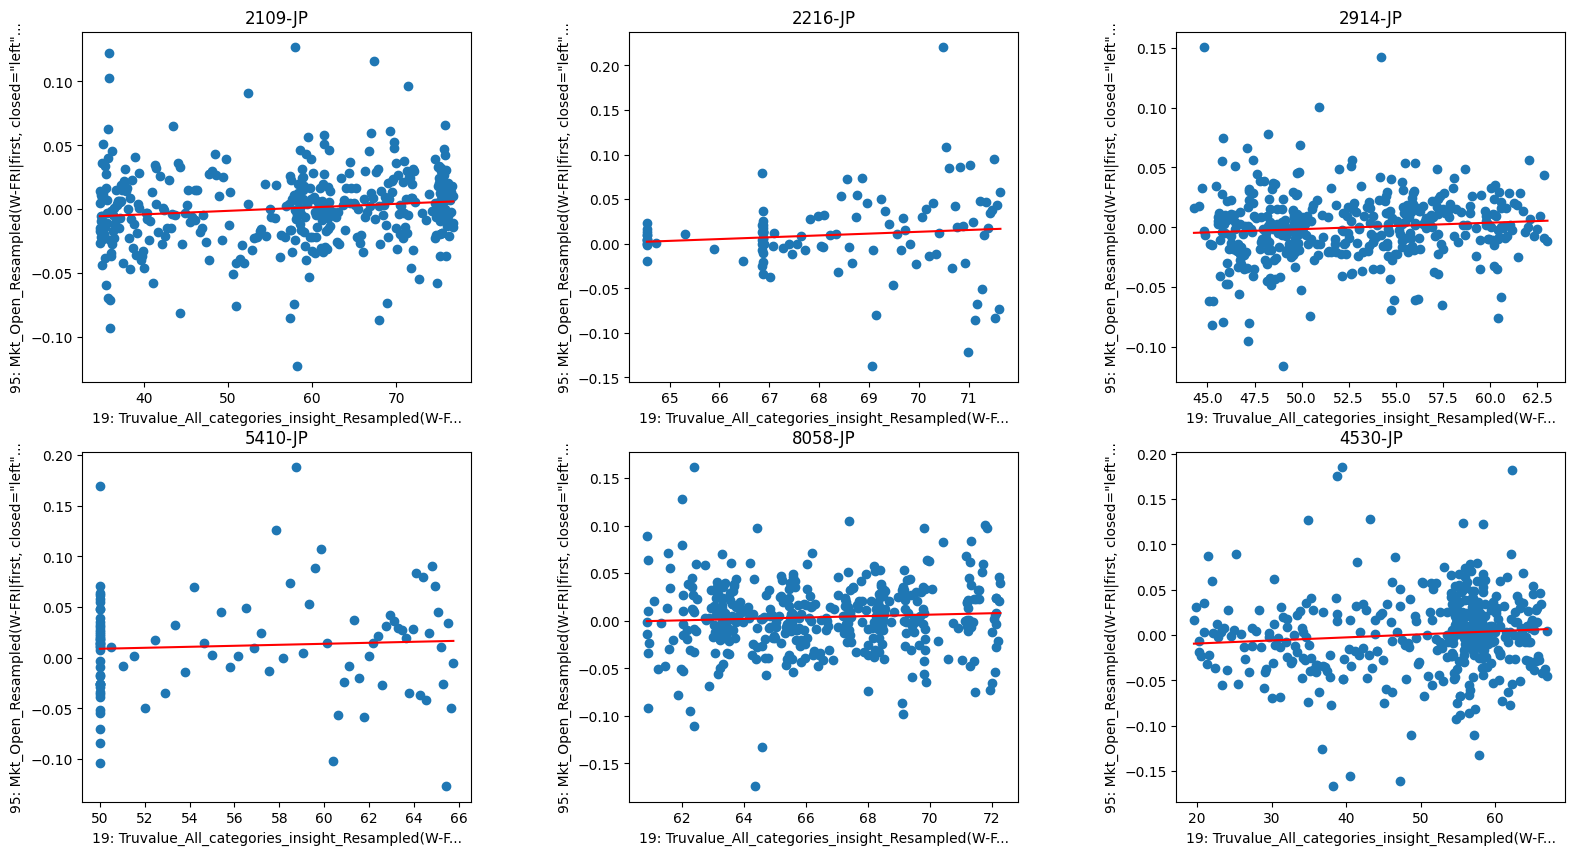

In [25]:
top6tickers = rho_time.T.xs('t-val', level=1).sort_values('ALL_CATEGORIES_PULSE', ascending=False).index[:6]

sdh.show_scatter_per_target(
    y=open_return,
    x=feature_sum,
    targets=top6tickers,
    col_num=3,
    vname_len_limit=45
)

## Quantile Backtest

> Perform portfolio analysis using the feature with the best correlation to stock price changes as a signal for each TruValue aggregation method.

In [26]:
# define the parameters for factor choice.
nq = 3
exe_cost = 0.0005

In [27]:
# Use the feature obtained by resampling with the last value.
dfqret, stats, dfsigqt = ade.q_backtest(
    feature_last,
    open_return,
    nq=nq,
    exe_cost=exe_cost,
    plot=True,
    stats=True
)

/home/schiba/work/notebooks_refs/asr_protected/asr_protected/portfolio/vectorized_allocator.py:185: UserWarning:

There are timestamps that do not match between the signal and return time series.



cum.Ret   ann.Ret   ann.Std       R/R     Win_R  \
001 #1           0.279857  0.045523  0.164248  0.277159  0.570694   
    #2           0.193160  0.031690  0.133713  0.237003  0.562982   
    #3           0.943292  0.095496  0.142774  0.668865  0.596401   
    #3-#1        0.441448  0.049973  0.079027  0.632361  0.537275   
    #3-#1(cost) -0.021996  0.000259  0.079016  0.003280  0.480720   

                 ann.TurnOver    Max_DD  Calmar Ratio  
001 #1               9.994066 -0.369716      0.123129  
    #2               9.994400 -0.309061      0.102537  
    #3               9.994384 -0.240857      0.396485  
    #3-#1           19.988451 -0.137666      0.363004  
    #3-#1(cost)     19.988451 -0.214720      0.001207

### Resample - mean

In [28]:
dfqret, stats, dfsigqt = ade.q_backtest(
    feature_mean,
    open_return,
    nq=nq,
    exe_cost=exe_cost,
    plot=True,
    stats=True
)

/home/schiba/work/notebooks_refs/asr_protected/asr_protected/portfolio/vectorized_allocator.py:185: UserWarning:

There are timestamps that do not match between the signal and return time series.



cum.Ret   ann.Ret   ann.Std       R/R     Win_R  \
001 #1           0.276688  0.044616  0.162373  0.274772  0.541667   
    #2           0.604166  0.075630  0.172624  0.438122  0.566176   
    #3           0.649176  0.078625  0.168993  0.465258  0.556373   
    #3-#1        0.288614  0.034010  0.055092  0.617322  0.534314   
    #3-#1(cost) -0.143067 -0.018261  0.055092 -0.331469  0.468137   

                 ann.TurnOver    Max_DD  Calmar Ratio  
001 #1               7.402484 -0.309709      0.144057  
    #2               7.402484 -0.329112      0.229801  
    #3               7.402484 -0.321407      0.244629  
    #3-#1           14.804968 -0.141377      0.240560  
    #3-#1(cost)     14.804968 -0.195526     -0.093396

### Resample - sum

In [29]:
dfqret, stats, dfsigqt = ade.q_backtest(
    feature_sum,
    open_return,
    nq=nq,
    exe_cost=exe_cost,
    plot=True,
    stats=True
)

/home/schiba/work/notebooks_refs/asr_protected/asr_protected/portfolio/vectorized_allocator.py:185: UserWarning:

There are timestamps that do not match between the signal and return time series.



cum.Ret   ann.Ret   ann.Std       R/R     Win_R  \
001 #1           0.418235  0.058609  0.165314  0.354529  0.541667   
    #2           0.163912  0.033586  0.167165  0.200914  0.544118   
    #3           0.994806  0.102937  0.168597  0.610551  0.578431   
    #3-#1        0.399358  0.044329  0.050378  0.879927  0.544118   
    #3-#1(cost)  0.390128  0.043480  0.050371  0.863187  0.544118   

                 ann.TurnOver    Max_DD  Calmar Ratio  
001 #1               0.753368 -0.355733      0.164755  
    #2               1.623296 -0.343627      0.097739  
    #3               0.927679 -0.284515      0.361800  
    #3-#1            1.681047 -0.077540      0.571688  
    #3-#1(cost)      1.681047 -0.078187      0.556106